In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# **Data & Pre-processing**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Masters Thesis/data/attribution_data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
# visit_order per cookie based on time order
df = df.sort_values(['cookie', 'time'], ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [ ]:
df_paths = df.groupby('cookie')['channel'].aggregate(lambda x: x.tolist()).reset_index()
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.drop(columns = ['cookie'], inplace = True)

In [ ]:
total_conversions = sum(df_paths['conversion'])
print("No. of conversions: ", total_conversions)

No. of conversions:  17639


In [ ]:
# reference: https://www.geeksforgeeks.org/highlight-the-maximum-value-in-each-column-in-pandas/
def highlight_max_attribution(row, df):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = row.loc['Attributed Credit'] == df['Attributed Credit'].max()
    return ['background-color: lightgreen' if is_max else '' for v in row.index]

# **Feature Engineering & train-test-split & SMOTE**

In [ ]:
# One-hot encode the touchpoints
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df_paths['channel'])
y = df_paths['conversion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# cannot use conversion_value here because directly indicative of conversion or not
# X_conversion_values = df_paths['conversion_value'].values.reshape(-1, 1)
# X = np.concatenate([X, X_conversion_values], axis=1)

In [ ]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
print("Total no. of instances before sampling:", len(y),
      "\nTotal no. of instances after sampling:", len(y_resampled))

print('\nResampled dataset shape:', Counter(y_resampled))

Total no. of instances before sampling: 240108 
Total no. of instances after sampling: 444938

Resampled dataset shape: Counter({0: 222469, 1: 222469})


In [ ]:
def evaluation_metrics(y_test, y_pred):
  print("Accuracy: ", round(accuracy_score(y_test, y_pred), 2))
  print("AUC score: ", round(roc_auc_score(y_test, y_pred), 2))
  print("\nClassification Report:\n", classification_report(y_test, y_pred))
  print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# **Random Forest**

## No Resampling/Class weights

In [ ]:
# Initialize and train a Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = model_rf.predict(X_test)

# Evaluate the Random Forest model
evaluation_metrics(y_test, y_pred_rf)

Accuracy:  0.93
AUC score:  0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     44455
           1       0.00      0.00      0.00      3567

    accuracy                           0.93     48022
   macro avg       0.46      0.50      0.48     48022
weighted avg       0.86      0.93      0.89     48022


Confusion Matrix:
 [[44455     0]
 [ 3567     0]]


In [ ]:
# Get feature importances from the Random Forest model
importances = model_rf.feature_importances_

# Create a DataFrame to map feature importances to channels
feature_names = mlb.classes_
attribution_df_rf = pd.DataFrame({'Channel': feature_names, 'Importance': importances})

# Calculate attributed credit by normalizing feature importances
attribution_df_rf['Attributed Credit'] = (attribution_df_rf['Importance'] / attribution_df_rf['Importance'].sum()) * total_conversions

# Calculate attributed credit percentage
attribution_df_rf['Attributed Credit %'] = round((attribution_df_rf['Importance'] / attribution_df_rf['Importance'].sum())*100, 2)
attribution_df_rf['Attributed Credit %'] = attribution_df_rf['Attributed Credit %'].apply(lambda x: f"{x:.2f}%")

# Sort by attributed credit in descending order
# attribution_df_rf = attribution_df_rf.sort_values('Attributed Credit', ascending=False)
attribution_df_rf.style.apply(highlight_max_attribution, df=attribution_df_rf, axis=1)

,Channel,Importance,Attributed Credit,Attributed Credit %
0,Facebook,0.277285,4891.031233,27.73%
1,Instagram,0.324788,5728.943905,32.48%
2,Online Display,0.052779,930.971036,5.28%
3,Online Video,0.294211,5189.584545,29.42%
4,Paid Search,0.050937,898.469281,5.09%


## Resampling using SMOTE

In [ ]:
# Initialize and train a Random Forest model with SMOTE
model_rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_resampled.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_rf = model_rf_resampled.predict(X_test_resampled)

# Evaluate the Random Forest model
evaluation_metrics(y_test_resampled, y_pred_rf)

Accuracy:  0.56
AUC score:  0.56

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.67      0.60     44453
           1       0.58      0.45      0.50     44535

    accuracy                           0.56     88988
   macro avg       0.56      0.56      0.55     88988
weighted avg       0.56      0.56      0.55     88988


Confusion Matrix:
 [[29845 14608]
 [24623 19912]]


In [ ]:
# Get feature importances from the Random Forest model
importances = model_rf_resampled.feature_importances_

# Create a DataFrame to map feature importances to channels
feature_names = mlb.classes_
attribution_df_rf = pd.DataFrame({'Channel': feature_names, 'Importance': importances})

# Calculate attributed credit by normalizing feature importances
attribution_df_rf['Attributed Credit'] = (attribution_df_rf['Importance'] / attribution_df_rf['Importance'].sum()) * total_conversions

# Calculate attributed credit percentage
attribution_df_rf['Attributed Credit %'] = round((attribution_df_rf['Importance'] / attribution_df_rf['Importance'].sum())*100, 2)
attribution_df_rf['Attributed Credit %'] = attribution_df_rf['Attributed Credit %'].apply(lambda x: f"{x:.2f}%")

# Sort by attributed credit in descending order
# attribution_df_rf = attribution_df_rf.sort_values('Attributed Credit', ascending=False)
attribution_df_rf.style.apply(highlight_max_attribution, df=attribution_df_rf, axis=1)

,Channel,Importance,Attributed Credit,Attributed Credit %
0,Facebook,0.253700,4475.011813,25.37%
1,Instagram,0.332136,5858.552345,33.21%
2,Online Display,0.049803,878.474984,4.98%
3,Online Video,0.312764,5516.835764,31.28%
4,Paid Search,0.051597,910.125094,5.16%


## Using Class weights

In [ ]:
# Train a Balanced Random Forest
balanced_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
balanced_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = balanced_rf.predict(X_test)

# Evaluate the Random Forest model
evaluation_metrics(y_test, y_pred)

Accuracy:  0.65
AUC score:  0.56

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.67      0.78     44455
           1       0.10      0.46      0.16      3567

    accuracy                           0.65     48022
   macro avg       0.52      0.56      0.47     48022
weighted avg       0.88      0.65      0.74     48022


Confusion Matrix:
 [[29819 14636]
 [ 1932  1635]]


In [ ]:
# Get feature importances from the Random Forest model
importances = balanced_rf.feature_importances_

# Create a DataFrame to map feature importances to channels
feature_names = mlb.classes_
attribution_df_rf = pd.DataFrame({'Channel': feature_names, 'Importance': importances})

# Calculate attributed credit by normalizing feature importances
attribution_df_rf['Attributed Credit'] = (attribution_df_rf['Importance'] / attribution_df_rf['Importance'].sum()) * total_conversions

# Calculate attributed credit percentage
attribution_df_rf['Attributed Credit %'] = round((attribution_df_rf['Importance'] / attribution_df_rf['Importance'].sum())*100, 2)
attribution_df_rf['Attributed Credit %'] = attribution_df_rf['Attributed Credit %'].apply(lambda x: f"{x:.2f}%")

# Sort by attributed credit in descending order
# attribution_df_rf = attribution_df_rf.sort_values('Attributed Credit', ascending=False)
attribution_df_rf.style.apply(highlight_max_attribution, df=attribution_df_rf, axis=1)

,Channel,Importance,Attributed Credit,Attributed Credit %
0,Facebook,0.256498,4524.364078,25.65%
1,Instagram,0.308547,5442.454941,30.85%
2,Online Display,0.071435,1260.044719,7.14%
3,Online Video,0.298360,5262.778721,29.84%
4,Paid Search,0.065160,1149.357540,6.52%


# SHAP

References:
* https://www.youtube.com/watch?v=L8_sVRhBDLU
* https://www.youtube.com/watch?v=MQ6fFDwjuco
* https://www.youtube.com/watch?v=2xlgOu22YgE&t=50s
* https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea
* https://christophm.github.io/interpretable-ml-book/shap.html

In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.3 MB/s eta 0:00:00


TreeExplainer: https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

In [ ]:
channels = mlb.classes_.tolist()

In [ ]:
# Implement SHAP (SHapley Additive exPlanations)
# Reference: https://shap.readthedocs.io/en/stable/generated/shap.TreeExplainer.html
explainer = shap.TreeExplainer(balanced_rf, X_train, feature_names=channels)
explanation = explainer(X_test)
shap_values = explanation.values

100%|===================| 95870/96044 [06:00<00:00]       

In [ ]:
# Implement SHAP (SHapley Additive exPlanations)
# Reference: https://shap.readthedocs.io/en/stable/generated/shap.TreeExplainer.html
explainer = shap.TreeExplainer(balanced_rf, X_train, feature_names=channels)
explanation = explainer(X_test)
shap_values = explanation.values

100%|===================| 95918/96044 [06:39<00:00]       

In [ ]:
X_test.shape

(48022, 5)

In [ ]:
shap_values.shape

(48022, 5, 2)

In [ ]:
explainer.expected_value

array([0.4943665, 0.5056335])

In [ ]:
shap_values_class_0 = explanation[:, :, 0]  # SHAP values for class 0
shap_values_class_1  = explanation[:, :, 1]  # SHAP values for class 1

## **Global Interpretability**

To understand the trends the model is using to make predictions in general

 Absolute Mean SHAP - to tell us which features are most important to the model --> average impact on model output magnitude

 each bar gives the absolute mean SHAP value for that feature --> kinda like feauture importance

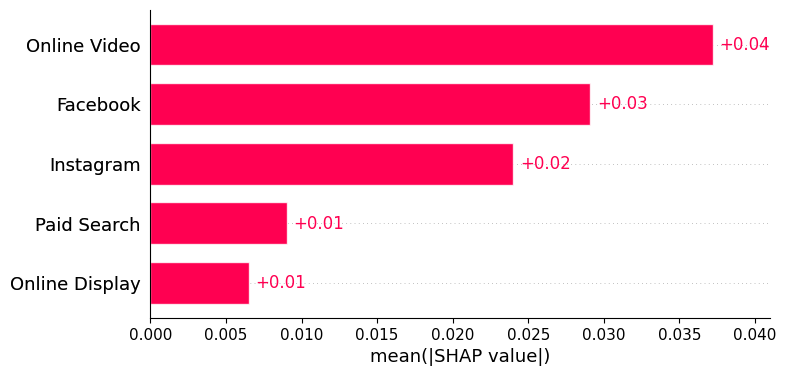

In [ ]:
shap.plots.bar(shap_values_class_0)

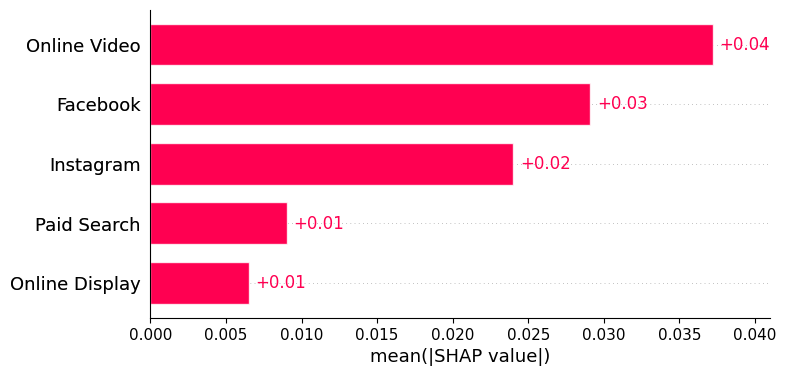

In [ ]:
shap.plots.bar(shap_values_class_1)

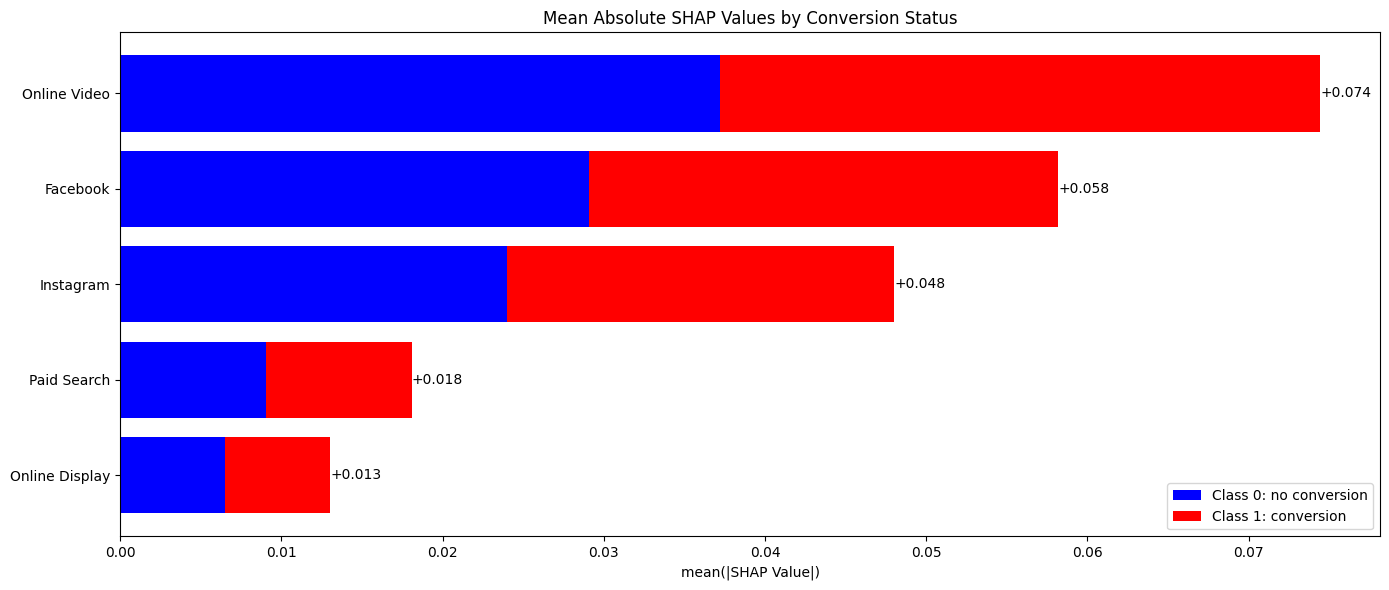

In [ ]:
# Calculate mean SHAP values for each feature
shap_values_class_0_mean = np.mean(np.abs(shap_values_class_0.values), axis=0)
shap_values_class_1_mean = np.mean(np.abs(shap_values_class_1.values), axis=0)

# Compute total SHAP values
total_shap_values = shap_values_class_0_mean + shap_values_class_1_mean

# Sort features by total SHAP values in descending order
sorted_indices = np.argsort(total_shap_values)
sorted_feature_names = np.array(channels)[sorted_indices]
sorted_shap_values_class_0 = shap_values_class_0_mean[sorted_indices]
sorted_shap_values_class_1 = shap_values_class_1_mean[sorted_indices]
sorted_total_shap_values = total_shap_values[sorted_indices] # sort the total shap values as well

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))  # Adjust figure size as needed

# Plot horizontal bars for class 0
ax.barh(sorted_feature_names, sorted_shap_values_class_0, label='Class 0: no conversion', color='blue')

# Plot horizontal bars for class 1 on top of class 0
ax.barh(sorted_feature_names, sorted_shap_values_class_1, left=sorted_shap_values_class_0, label='Class 1: conversion', color='red')

# Set labels and title
ax.set_xlabel('mean(|SHAP Value|)')
ax.set_title('Mean Absolute SHAP Values by Conversion Status')
ax.set_yticks(sorted_feature_names)  # Use sorted feature names for y-axis ticks
ax.set_yticklabels(sorted_feature_names)

# Add total SHAP values as text labels to the right of the bars
for i, v in enumerate(sorted_total_shap_values):
    ax.text(v, i, "+"+str(round(v, 3)), color='black', va='center')

ax.legend()
plt.tight_layout()
plt.show()

beeswarm plot - visualisation of all SHAP values

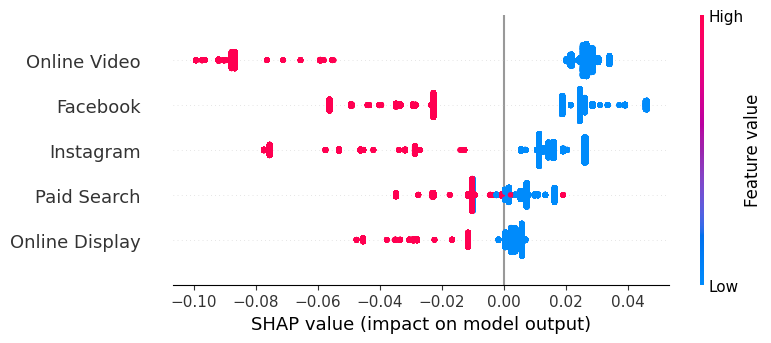

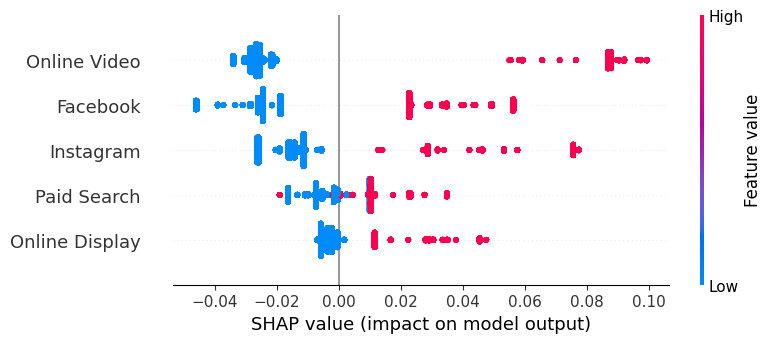

In [ ]:
# Visualize the SHAP values for class 0
shap.plots.beeswarm(shap_values_class_0)

# Visualize the SHAP values for class 1
shap.plots.beeswarm(shap_values_class_1)

## **Local Interpretability**

The SHAP waterfall plot and force plot (which is kind of like a condensed waterfall plot) are useful for understanding how the model has made individual predictions

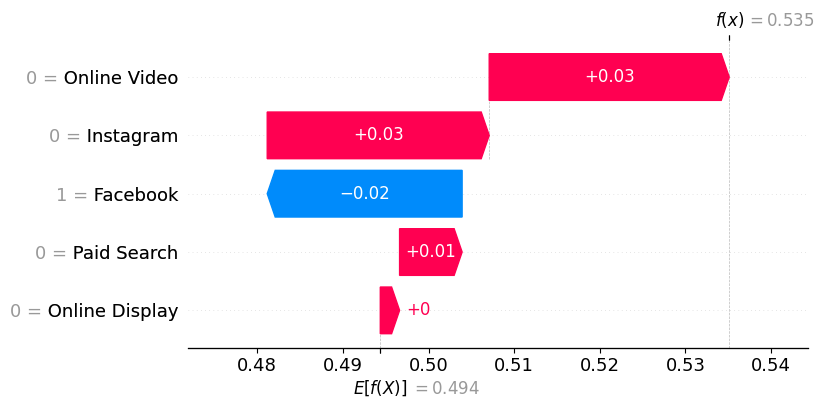

In [ ]:
# E[f(x)] --> average predicted log odds
# f(x) --> predicted log odds for specified instance
row = 10
shap.plots.waterfall(shap_values_class_0[row])

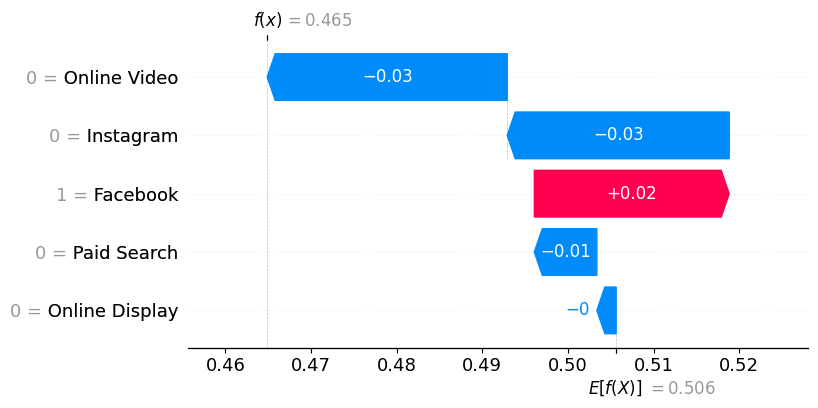

In [ ]:
shap.plots.waterfall(shap_values_class_1[row])

In [ ]:
# Represent X_test[row] using mlb.classes_.tolist()
pd.Series(X_test[row], index=channels)

,0
Facebook,1
Instagram,0
Online Display,0
Online Video,0
Paid Search,0


In [ ]:
shap.initjs()
shap.force_plot(shap_values_class_0[row], X_test[row])

In [ ]:
shap.initjs()
shap.force_plot(shap_values_class_1[row], X_test[row])

---